In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Visualization

In [3]:
orig_train_data = pd.read_csv("data/Tabular Playground Series - May 2021/train.csv")
orig_test_data = pd.read_csv("data/Tabular Playground Series - May 2021/test.csv")

In [4]:
orig_train_data.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


In [5]:
orig_test_data.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,...,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


### Dropping ID Column

In [6]:
orig_train_data.drop("id", axis=1, inplace=True)

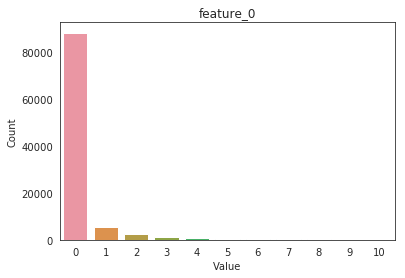

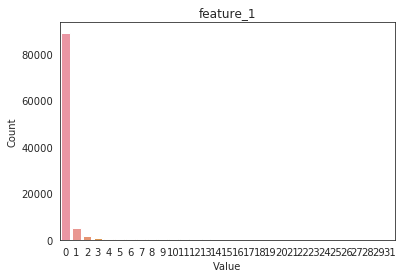

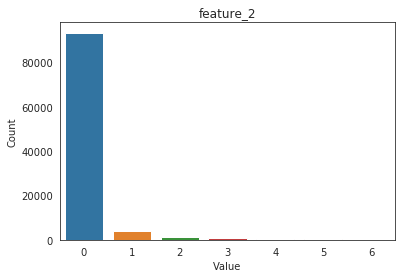

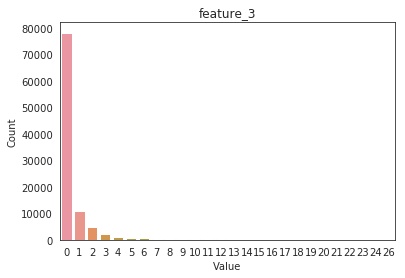

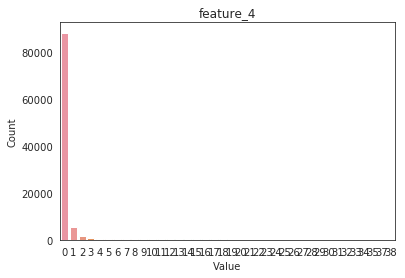

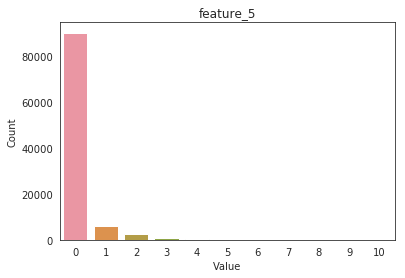

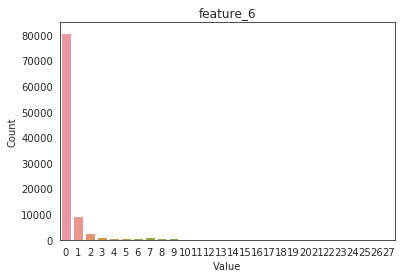

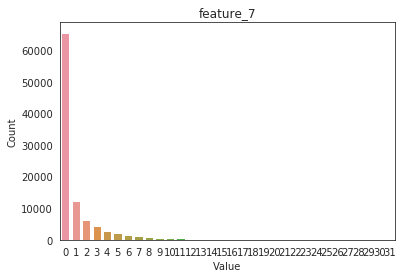

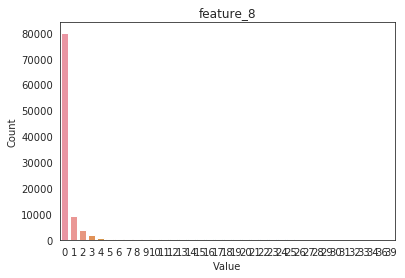

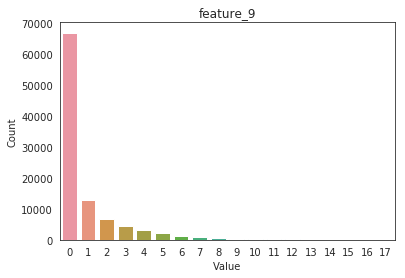

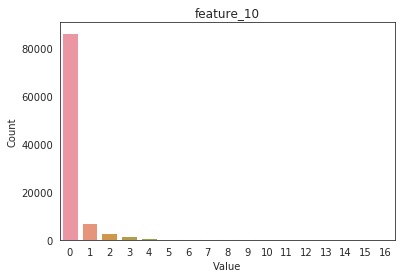

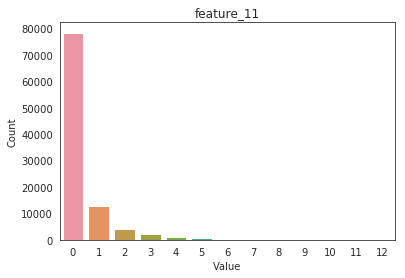

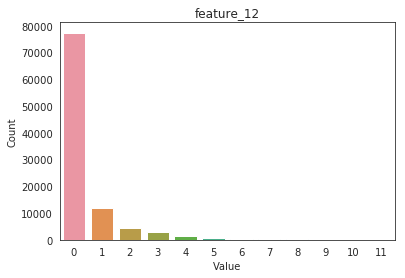

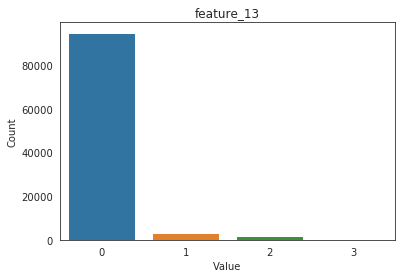

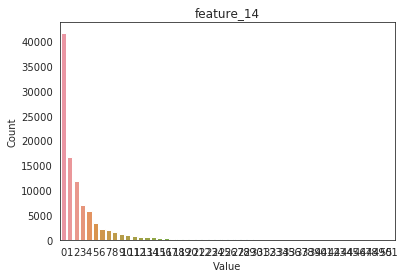

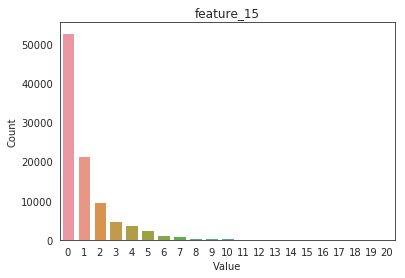

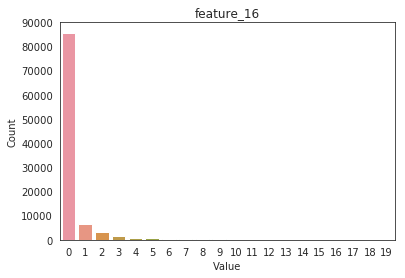

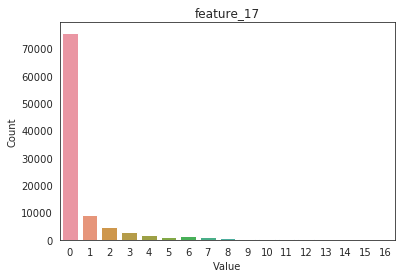

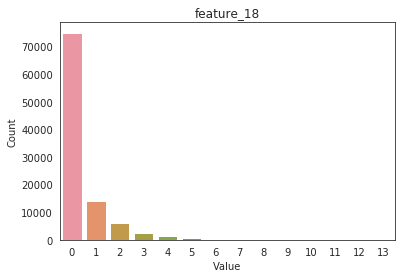

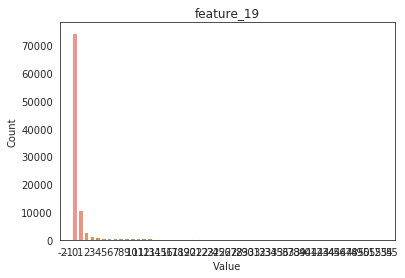

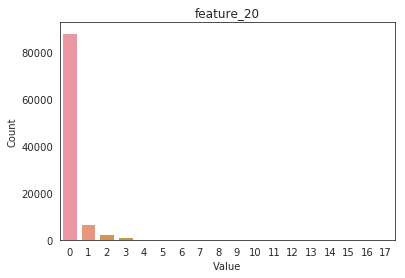

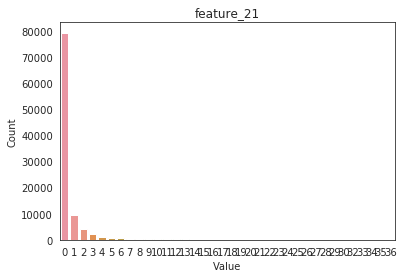

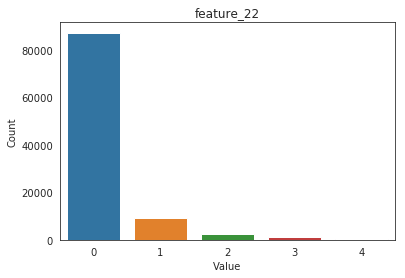

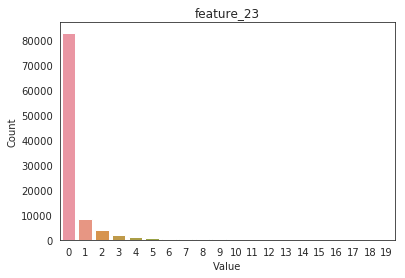

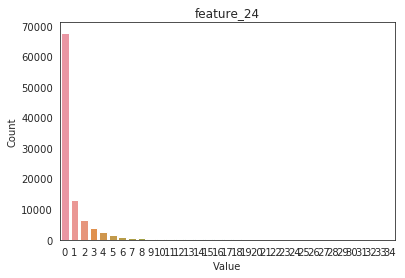

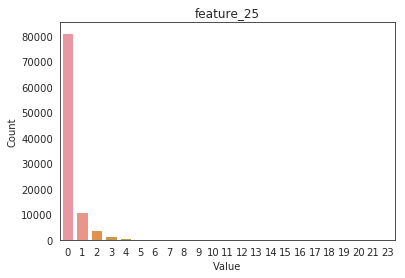

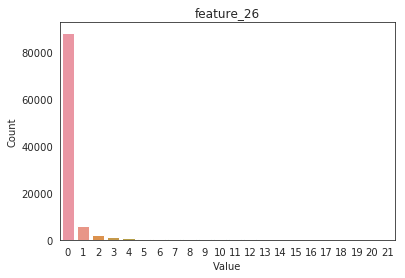

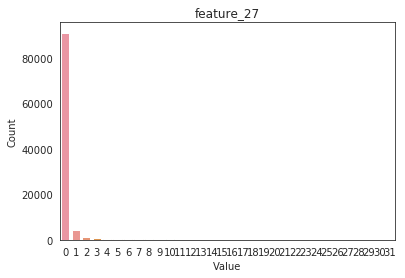

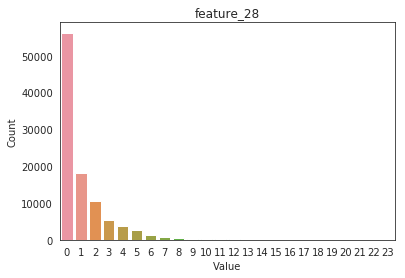

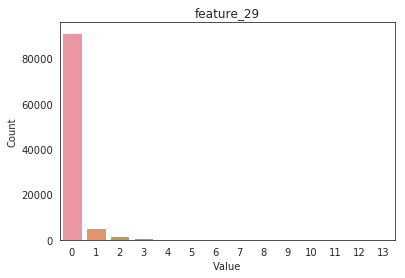

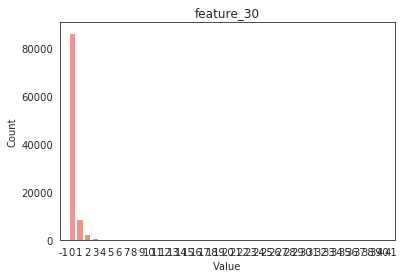

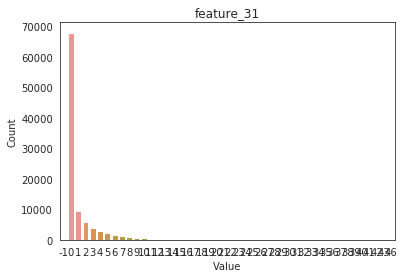

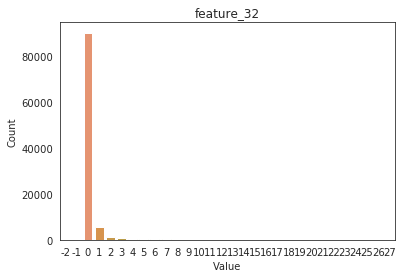

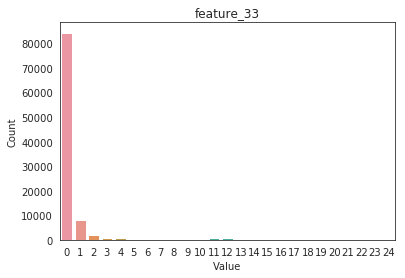

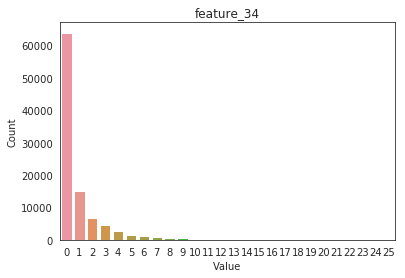

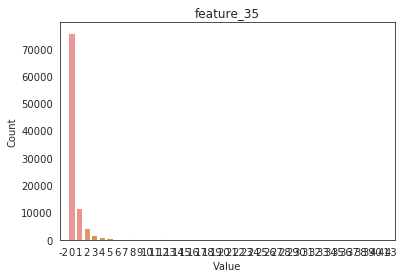

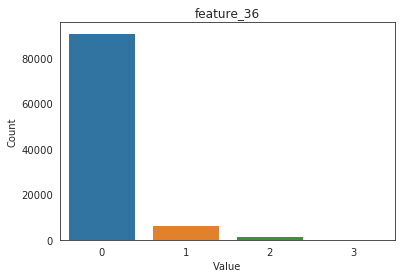

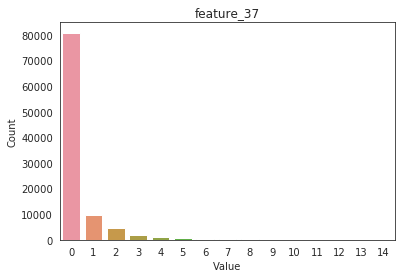

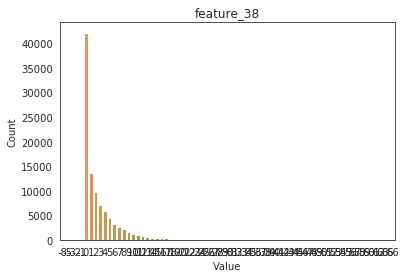

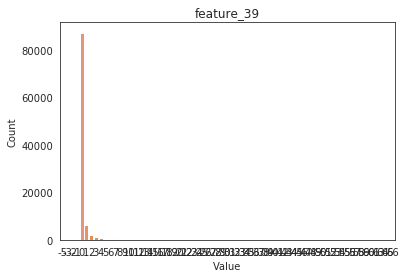

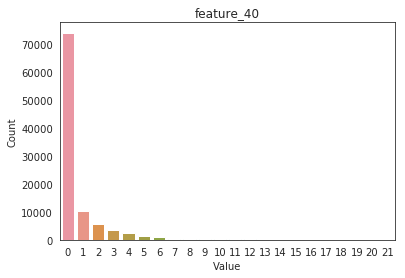

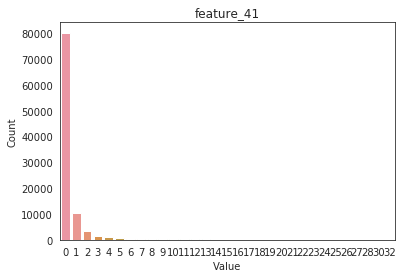

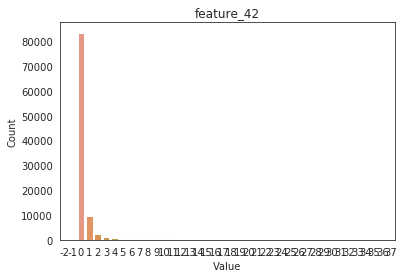

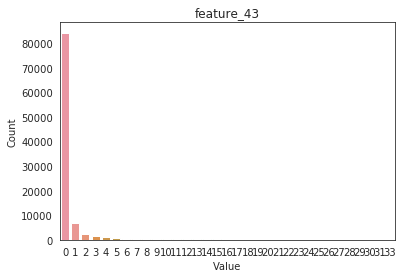

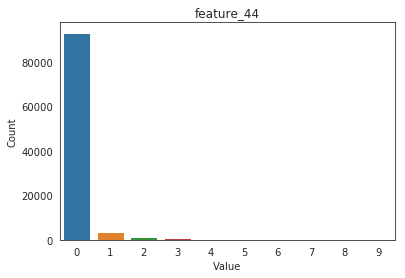

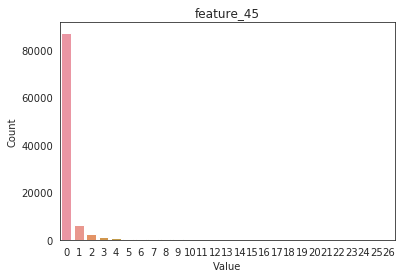

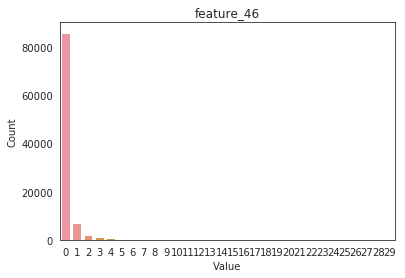

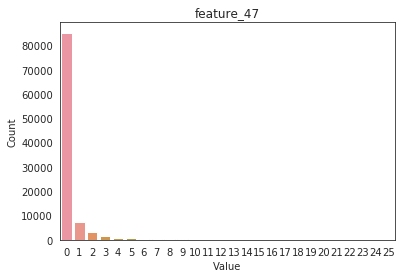

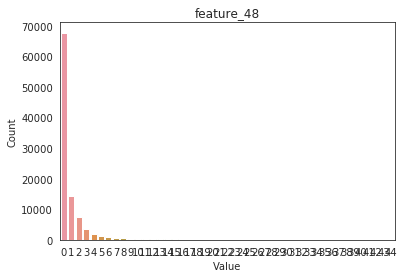

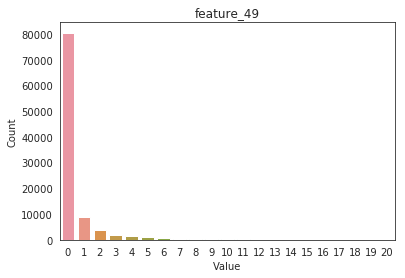

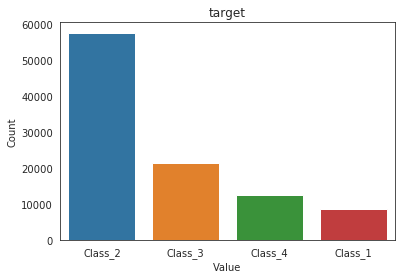

In [124]:
for i in orig_train_data.columns:
    df = pd.DataFrame(orig_train_data[i].value_counts())
    sns.barplot(x=df.index, y=df[i], data=df)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(i)
    plt.show()

In [ ]:
# sns.pairplot(orig_train_data)

In [7]:
orig_train_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,1,0,1,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,13,2,0,Class_1
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


### Review Data Distribution

In [8]:
class_1_data = orig_train_data[orig_train_data.target=="Class_1"]
class_1_data.shape

(8490, 51)

In [9]:
class_2_data = orig_train_data[orig_train_data.target=="Class_2"]
class_2_data.shape

(57497, 51)

In [10]:
class_3_data = orig_train_data[orig_train_data.target=="Class_3"]
class_3_data.shape

(21420, 51)

In [11]:
class_4_data = orig_train_data[orig_train_data.target=="Class_4"]
class_4_data.shape

(12593, 51)

In [12]:
type(class_1_data), type(class_2_data), type(class_3_data), type(class_4_data)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

### Balance the Data

In [13]:
class_2_data = class_2_data.iloc[:8490,:]
class_2_data.shape

(8490, 51)

In [14]:
class_3_data = class_3_data.iloc[:8490,:]
class_3_data.shape

(8490, 51)

In [15]:
class_4_data = class_4_data.iloc[:8490,:]
class_4_data.shape

(8490, 51)

In [16]:
type(class_1_data), type(class_2_data), type(class_3_data), type(class_4_data)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

### Combine all Class 1 to 4 Dataset

In [46]:
from sklearn.utils import shuffle
balanced_data = [class_1_data, class_2_data, class_3_data, class_4_data]
balanced_data = pd.concat(balanced_data)
balanced_data = shuffle(balanced_data).reset_index(drop=True)
balanced_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,8,0,0,0,1,0,0,3,0,...,0,10,0,0,3,0,1,0,0,Class_1
1,0,0,0,0,13,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,Class_1
2,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,Class_3
3,0,1,1,0,0,0,0,0,0,2,...,0,0,0,0,2,0,0,0,0,Class_2
4,0,0,0,0,0,0,0,10,1,1,...,0,12,0,0,0,0,1,0,0,Class_2


### Remove Duplicates

In [47]:
balanced_data = balanced_data[balanced_data.duplicated()==False]
balanced_data.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,8,0,0,0,1,0,0,3,0,...,0,10,0,0,3,0,1,0,0,Class_1
1,0,0,0,0,13,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,Class_1
2,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,Class_3
3,0,1,1,0,0,0,0,0,0,2,...,0,0,0,0,2,0,0,0,0,Class_2
4,0,0,0,0,0,0,0,10,1,1,...,0,12,0,0,0,0,1,0,0,Class_2


In [48]:
target = balanced_data["target"]

In [49]:
balanced_data.drop("target", axis=1, inplace=True)

In [50]:
balanced_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,8,0,0,0,1,0,0,3,0,...,0,0,10,0,0,3,0,1,0,0
1,0,0,0,0,13,0,1,0,0,1,...,2,0,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,1,0
3,0,1,1,0,0,0,0,0,0,2,...,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,0,0,10,1,1,...,0,0,12,0,0,0,0,1,0,0


### Check for Correlated Features

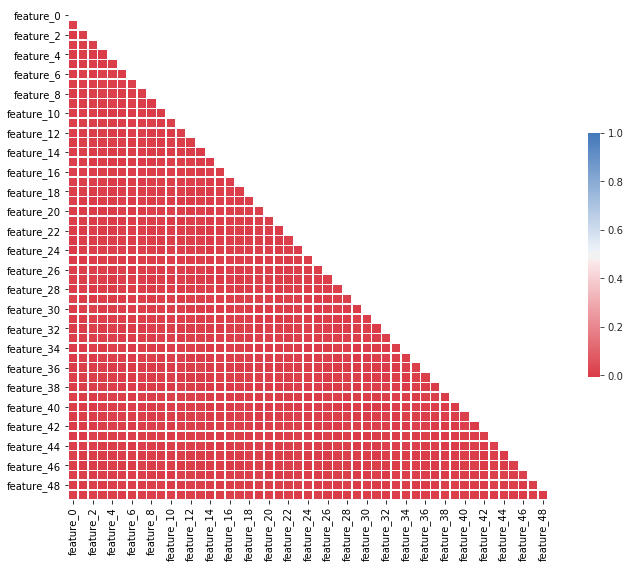

In [21]:
corr = orig_train_data.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Apply StandardScalar

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
balanced_data = pd.DataFrame(scaler.fit_transform(balanced_data), columns=balanced_data.columns)
balanced_data

/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0.0,0.275862,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.088235,0.000000,...,0.00,0.00000,0.342857,0.000000,0.000000,0.115385,0.000000,0.04,0.000000,0.00
1,0.0,0.000000,0.000000,0.000000,0.371429,0.0,0.037037,0.000000,0.000000,0.058824,...,0.10,0.00000,0.057143,0.032258,0.000000,0.000000,0.000000,0.00,0.023256,0.05
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.035714,0.000000,0.058824,...,0.05,0.00000,0.085714,0.000000,0.000000,0.000000,0.000000,0.00,0.023256,0.00
3,0.0,0.034483,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.117647,...,0.00,0.00000,0.057143,0.000000,0.000000,0.076923,0.000000,0.00,0.000000,0.00
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.357143,0.029412,0.058824,...,0.00,0.00000,0.400000,0.000000,0.000000,0.000000,0.000000,0.04,0.000000,0.00
5,0.0,0.000000,0.000000,0.153846,0.514286,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00,0.12500,0.057143,0.000000,0.000000,0.000000,0.142857,0.12,0.046512,0.00
6,0.0,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.035714,0.000000,0.000000,...,0.00,0.00000,0.057143,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
7,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.071429,0.000000,0.000000,...,0.05,0.00000,0.057143,0.000000,0.111111,0.000000,0.000000,0.20,0.000000,0.05
8,0.0,0.000000,0.000000,0.038462,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.057143,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.15
9,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.035714,0.000000,0.000000,...,0.00,0.00000,0.057143,0.032258,0.000000,0.000000,0.000000,0.00,0.000000,0.00


### Prepare and Process Test Data

In [60]:
orig_test_data.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,...,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


In [61]:
orig_test_data_id = orig_test_data.id
orig_test_data.drop("id", axis=1, inplace=True)
orig_test_data_id.head()

0    100000
1    100001
2    100002
3    100003
4    100004
Name: id, dtype: int64

In [62]:
orig_test_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,0,0,0,0,4,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,2,0,7,7,...,3,0,1,0,0,0,1,0,2,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,6,9,14,3
4,0,0,0,0,0,0,1,0,4,0,...,1,0,0,0,0,0,0,0,0,0


### Scale Test Data

In [65]:
orig_test_data = pd.DataFrame(scaler.fit_transform(orig_test_data), columns=orig_test_data.columns)
orig_test_data.head(5)

/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.16,0.137931,0.000000,0.0000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.166667,0.0,0.0,0.0,0.08,0.000000,0.200000,0.4375,...,0.130435,0.0,0.027778,0.000000,0.0,0.0,0.034483,0.000000,0.043478,0.047619
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.028571,0.0000,...,0.000000,0.0,0.000000,0.033333,0.0,0.0,0.000000,0.000000,0.130435,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.034483,0.028571,0.0000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.206897,0.346154,0.304348,0.142857
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.04,0.000000,0.114286,0.0000,...,0.043478,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


### SGDClassifier

In [52]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sgd_pipeline = make_pipeline(SGDClassifier(loss="log"))

sgd_pipeline.fit(X=balanced_data, y=target)

/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('sgdclassifier', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [53]:
sgd_output = pd.DataFrame(sgd_pipeline.predict_proba(balanced_data), columns=sgd_pipeline.classes_)
sgd_output.head()

,Class_1,Class_2,Class_3,Class_4
0,0.284724,0.182604,0.269646,0.263025
1,0.344751,0.261551,0.199767,0.193931
2,0.252348,0.203645,0.249694,0.294312
3,0.263262,0.198583,0.243974,0.294182
4,0.272516,0.200591,0.236998,0.289895


### Predicting with SGD Classifier

In [69]:
sgd_output = pd.DataFrame(sgd_pipeline.predict_proba(orig_test_data), columns=sgd_pipeline.classes_)

In [70]:
sgd_output.to_csv("data/Tabular Playground Series - May 2021/sgd_output_submission.csv")

### OneVsRestClassifier

In [54]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

ovr_pipeline = make_pipeline(OneVsRestClassifier(SVC(probability=True)))
ovr_pipeline.fit(balanced_data, target)

/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this wa

Pipeline(memory=None,
     steps=[('onevsrestclassifier', OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None))])

In [55]:
pd.DataFrame(ovr_pipeline.predict_proba(balanced_data), columns=ovr_pipeline.classes_).head()

,Class_1,Class_2,Class_3,Class_4
0,0.248191,0.245317,0.269695,0.236797
1,0.275671,0.284062,0.233580,0.206687
2,0.257272,0.251290,0.258097,0.233341
3,0.252361,0.256033,0.258762,0.232843
4,0.252676,0.286687,0.247882,0.212754


### Predicting with OneVsRestClassifier

In [67]:
output = pd.DataFrame(ovr_pipeline.predict_proba(orig_test_data), columns=ovr_pipeline.classes_)

In [68]:
output.to_csv("data/Tabular Playground Series - May 2021/ovr_output_submission.csv")

### Split data in Train and Test Set

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(balanced_data, target, test_size=0.2, random_state=42)

In [72]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((27168, 50), (6792, 50), (27168,), (6792,))

### DecisionTreeClassifier

In [73]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, cross_val_score

In [74]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {"max_features": [10, 20, 40],
              "max_depth": [5, 10, 20],
              "min_samples_split": [5, 10, 20],
              "min_samples_leaf": [5, 10, 20]
}

dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring="accuracy", cv=kfold, n_jobs=4, refit=True)

# ovr_clf = OneVsRestClassifier(dt_clf)
# ovr_pipeline = make_pipeline(StandardScaler(), OneVsRestClassifier(dt_clf))

dt_clf.fit(x_train, y_train)

# Best score
print(dt_clf.best_score_)

# Best Estimator
print(dt_clf.best_estimator_)


0.28209658421672557
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### RandomForestClassifier

In [75]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, cross_val_score

In [76]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {"max_features": [10, 20, 40],
              "max_depth": [5, 10, 20],
              "min_samples_split": [5, 10, 20],
              "min_samples_leaf": [5, 10, 20]
             }

rnd_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring="accuracy", cv=kfold, n_jobs=4)

rnd_clf.fit(x_train, y_train)

# Best score
print(rnd_clf.best_score_)

# Best Estimator
print(rnd_clf.best_estimator_)

/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.29807126030624265
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### ANN

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [117]:
def encode_target(data):
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(data)
    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_target = encoded_target.reshape(len(encoded_target), 1)
    ohe_target = one_hot_encoder.fit_transform(encoded_target)
    print(ohe_target)
    return ohe_target

#### LabelEncode the Target Classes and OneHotEncode Target Classes

In [41]:
ohe_target = encode_target(target)

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [76]:
def ann_model():
    model = Sequential()
    model.add(Dense(balanced_data.shape[1], activation="relu", input_dim=balanced_data.shape[1]))
    model.add(Dropout(5))
    model.add(BatchNormalization())
    model.add(Dense(164, activation="relu"))
    model.add(Dropout(5))
    model.add(BatchNormalization())
    model.add(Dense(4, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [77]:
ann_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_33 (Dropout)         (None, 50)                0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 50)                200       
_________________________________________________________________
dense_50 (Dense)             (None, 164)               8364      
_________________________________________________________________
dropout_34 (Dropout)         (None, 164)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 164)               656       
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 660       
Total para

In [85]:
balanced_data.shape, ohe_target.shape

((33960, 50), (33960, 4))

In [80]:
estimator = KerasClassifier(build_fn=ann_model, epochs=10, batch_size=5, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, balanced_data, ohe_target, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_37 (Dropout)         (None, 50)                0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 50)                200       
_________________________________________________________________
dense_56 (Dense)             (None, 164)               8364      
_________________________________________________________________
dropout_38 (Dropout)         (None, 164)               0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 164)               656       
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 660       
Total para

KeyboardInterrupt: 

### Calculate Information Gain

In [1]:
from sklearn.feature_selection import mutual_info_classif

importance = mutual_info_classif(x_train, y_train)
feature_importance = pd.DataFrame(importance, x_train.columns[0:len(x_train.columns)])

NameError: name 'x_train' is not defined

In [62]:
feature_importance[feature_importance.values > 0.000000]

,0
feature_1,0.003753
feature_5,0.004219
feature_7,0.004929
feature_9,0.001227
feature_11,0.003896
feature_12,0.008444
feature_13,0.000013
feature_14,0.004668
feature_15,0.000836
feature_16,0.006868


In [64]:
from sklearn.feature_selection import SelectKBest

selectkbest = SelectKBest(mutual_info_classif, k=10).fit(x_train, y_train)
x_train.columns[selectkbest.get_support()]

Index(['feature_4', 'feature_6', 'feature_15', 'feature_16', 'feature_22',
       'feature_29', 'feature_31', 'feature_35', 'feature_43', 'feature_49'],
      dtype='object')

In [83]:
x_train_ig = selectkbest.transform(x_train)
x_test_ig = selectkbest.transform(x_test)

x_train_ig.shape, x_test_ig.shape

((27168, 10), (6792, 10))

In [118]:
y_train_ig = encode_target(y_train)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


/Users/gajendrasahu/opt/anaconda3/envs/datasciencebasics/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [119]:
y_train_ig.shape

(27168, 4)

### Retrain ANN with New Data

In [120]:
def ann_model():
    model = Sequential()
    model.add(Dense(x_train_ig.shape[1], activation="relu", input_dim=x_train_ig.shape[1]))
    model.add(Dropout(5))
    model.add(BatchNormalization())
    model.add(Dense(164, activation="relu"))
    model.add(Dropout(5))
    model.add(BatchNormalization())
    model.add(Dense(4, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [121]:
ann_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_41 (Dropout)         (None, 10)                0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 10)                40        
_________________________________________________________________
dense_62 (Dense)             (None, 164)               1804      
_________________________________________________________________
dropout_42 (Dropout)         (None, 164)               0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 164)               656       
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 660       
Total para

In [123]:
estimator = KerasClassifier(build_fn=ann_model, epochs=20, batch_size=1, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, x_train_ig, y_train_ig, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_63 (Dropout)         (None, 10)                0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 10)                40        
_________________________________________________________________
dense_95 (Dense)             (None, 164)               1804      
_________________________________________________________________
dropout_64 (Dropout)         (None, 164)               0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 164)               656       
_________________________________________________________________
dense_96 (Dense)             (None, 4)                 660       
Total para

24451/24451 [==============================] - 168s 7ms/step - loss: 1.3877 - acc: 0.2470
Epoch 3/20
24451/24451 [==============================] - 170s 7ms/step - loss: 1.3873 - acc: 0.2492
Epoch 4/20
24451/24451 [==============================] - 169s 7ms/step - loss: 1.3874 - acc: 0.2524
Epoch 5/20
24451/24451 [==============================] - 166s 7ms/step - loss: 1.3876 - acc: 0.2482
Epoch 6/20
24451/24451 [==============================] - 166s 7ms/step - loss: 1.3877 - acc: 0.2490
Epoch 7/20
24451/24451 [==============================] - 167s 7ms/step - loss: 1.3877 - acc: 0.2467
Epoch 8/20
24451/24451 [==============================] - 166s 7ms/step - loss: 1.3876 - acc: 0.2445
Epoch 9/20
24451/24451 [==============================] - 166s 7ms/step - loss: 1.3876 - acc: 0.2472
Epoch 10/20
24451/24451 [==============================] - 179s 7ms/step - loss: 1.3875 - acc: 0.2503
Epoch 11/20
24451/24451 [==============================] - 167s 7ms/step - loss: 1.3877 - acc: 0.2462

24451/24451 [==============================] - 164s 7ms/step - loss: 1.3876 - acc: 0.2505
Epoch 17/20
24451/24451 [==============================] - 164s 7ms/step - loss: 1.3875 - acc: 0.2489
Epoch 18/20
24451/24451 [==============================] - 167s 7ms/step - loss: 1.3878 - acc: 0.2485
Epoch 19/20
24451/24451 [==============================] - 164s 7ms/step - loss: 1.3875 - acc: 0.2510
Epoch 20/20
2717/2717 [==============================] - 11s 4ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 10)                110       
_________________________________________________________________
dropout_73 (Dropout)         (None, 10)                0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 10)                40        
_________________________________________________________________
dense_

Epoch 1/20
24451/24451 [==============================] - 203s 8ms/step - loss: 1.3877 - acc: 0.2484
Epoch 2/20
24451/24451 [==============================] - 179s 7ms/step - loss: 1.3875 - acc: 0.2455
Epoch 3/20
24451/24451 [==============================] - 168s 7ms/step - loss: 1.3876 - acc: 0.2521
Epoch 4/20
24451/24451 [==============================] - 194s 8ms/step - loss: 1.3877 - acc: 0.2510
Epoch 5/20
24451/24451 [==============================] - 191s 8ms/step - loss: 1.3875 - acc: 0.2550
Epoch 6/20
24451/24451 [==============================] - 199s 8ms/step - loss: 1.3877 - acc: 0.2473
Epoch 7/20
24451/24451 [==============================] - 169s 7ms/step - loss: 1.3878 - acc: 0.2453
Epoch 8/20
24451/24451 [==============================] - 199s 8ms/step - loss: 1.3876 - acc: 0.2480
Epoch 9/20
24451/24451 [==============================] - 192s 8ms/step - loss: 1.3874 - acc: 0.2542
Epoch 10/20
24451/24451 [==============================] - 197s 8ms/step - loss: 1.3877 - a

24452/24452 [==============================] - 207s 8ms/step - loss: 1.3876 - acc: 0.2499
Epoch 16/20
24452/24452 [==============================] - 192s 8ms/step - loss: 1.3876 - acc: 0.2480
Epoch 17/20
24452/24452 [==============================] - 195s 8ms/step - loss: 1.3877 - acc: 0.2467
Epoch 18/20
24452/24452 [==============================] - 216s 9ms/step - loss: 1.3875 - acc: 0.2507
Epoch 19/20
24452/24452 [==============================] - 203s 8ms/step - loss: 1.3877 - acc: 0.2497
Epoch 20/20
2716/2716 [==============================] - 12s 5ms/step
Baseline: 25.02% (1.05%)


In [ ]:
Baseline: 26.82% (0.88%)